# CoAtNet

According to [arXiv:2106.04803 [cs.CV]](https://arxiv.org/abs/2106.04803)

In terms of generalization capability
$$
\text{C-C-C-C} \approx \text{C-C-C-T} \geq \text{C-C-T-T} > \text{C-T-T-T} \gg \text{VIT}_{\mathrm{REL}}
$$

For model capacity
$$
\text{C-C-T-T} \approx \text{C-T-T-T} > \text{VIT}_{\mathrm{REL}} > \text{C-C-C-T} > \text{C-C-C-C}
$$

For transferability
$$
\text{C-C-T-T} > \text{C-T-T-T}
$$

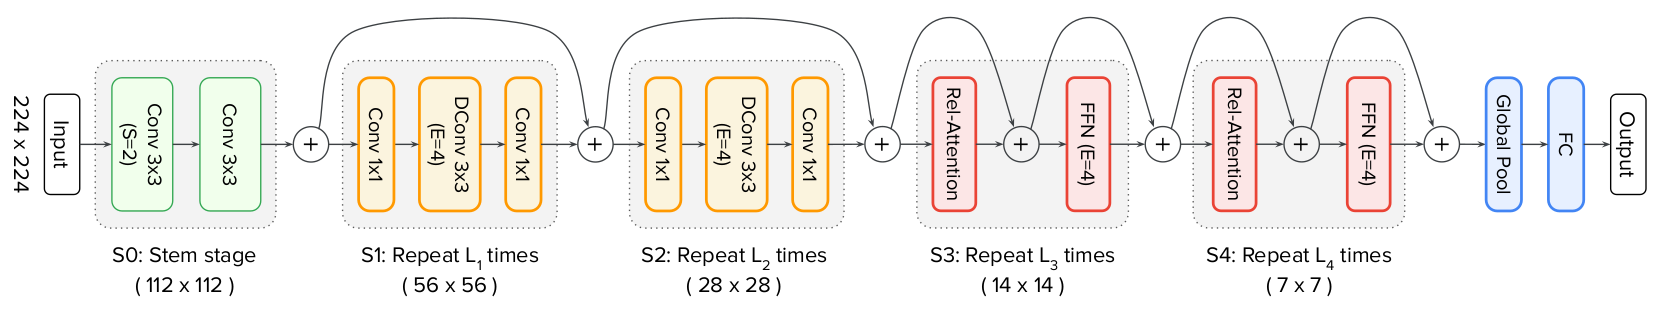

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_WORKERS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1
EPOCHS = 100

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

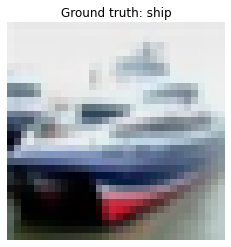

In [8]:
dataset_show_image(test_dset, 1)

## Model

Utilities

In [9]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [10]:
class Partial:
    def __init__(self, module, *args, **kwargs):
        self.module = module
        self.args = args
        self.kwargs = kwargs

    def __call__(self, *args_c, **kwargs_c):
        return self.module(*args_c, *self.args, **kwargs_c, **self.kwargs)

In [11]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [12]:
class Residual(nn.Module):
    def __init__(self, *layers, shortcut=None):
        super().__init__()
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

In [13]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                      groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

In [14]:
def get_shortcut(in_channels, out_channels, stride):
    if (in_channels == out_channels and stride == 1):
        shortcut = nn.Identity()
    else:
        shortcut = nn.Conv2d(in_channels, out_channels, 1)

    if stride > 1:
        shortcut = nn.Sequential(nn.MaxPool2d(stride), shortcut)
    
    return shortcut

Squeeze-and-Excitation, [arXiv:1709.01507 [cs.CV]](https://arxiv.org/abs/1709.01507)

In [15]:
class SqueezeExciteBlock(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.out_channels = channels
        channels_r = channels // reduction
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels_r, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(channels_r, channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return x * self.se(x)

MobileNetV2, [arXiv:1801.04381 [cs.CV]](https://arxiv.org/abs/1801.04381)

MnasNet, [arXiv:1807.11626 [cs.CV]](https://arxiv.org/abs/1807.11626)

In [16]:
class MBConv(Residual):
    def __init__(self, in_channels, out_channels, shape, kernel_size=3, stride=1, expansion_factor=4):
        mid_channels = in_channels * expansion_factor
        super().__init__(
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
            ConvBlock(in_channels, mid_channels, 1), # Pointwise
            ConvBlock(mid_channels, mid_channels, kernel_size, stride=stride, groups=mid_channels), # Depthwise
            SqueezeExciteBlock(mid_channels),
            nn.Conv2d(mid_channels, out_channels, 1), # Pointwise
            shortcut = get_shortcut(in_channels, out_channels, stride)
        )

Attention

$$
O = V \mathrm{softmax}\left[\frac{1}{\sqrt{c}}K^{\intercal}Q\right]
$$

**Calculation of indices for relative position encoding**

Flattening of indices: $i,j \rightarrow W i +j$

We want $P[W i + j, W i' + j'] = w[i - i', j - j']$

Since we index the elements of $w$ from $0$, then $P[W i + j, W i' + j'] = w[i - i' + H - 1 , j - j' + W - 1]$

Flattening:
$$
P[(W i + j) H W + W i' + j'] = w[(i - i' + H - 1) (2 W - 1) + j - j' + W - 1]
$$

In [17]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape, p_drop=0.):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5
        
        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)
        
        height, width = shape
        self.pos_enc = nn.Parameter(torch.randn(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))

        self.drop = nn.Dropout(p_drop)
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)
        
        att = keys.transpose(-2, -1) @ queries
        
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))
        
        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)
        
        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        out = self.drop(out)
        return out
    
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices

Transformer

In [18]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4, p_drop=0.):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1),
            nn.Dropout(p_drop)
        )

In [19]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, head_channels, shape, stride=1, p_drop=0.):
        shape = (shape[0] // stride, shape[1] // stride)
        super().__init__(
            Residual(
                LayerNormChannels(in_channels),
                nn.MaxPool2d(stride) if stride > 1 else nn.Identity(),
                SelfAttention2d(in_channels, out_channels, head_channels, shape, p_drop=p_drop),
                shortcut = get_shortcut(in_channels, out_channels, stride)
            ),
            Residual(
                LayerNormChannels(out_channels),
                FeedForward(out_channels, out_channels, p_drop=p_drop)
            )
        )

Full model

In [20]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3, stride=stride),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

In [21]:
class Head(nn.Sequential):
    def __init__(self, channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(channels, classes)
        )

In [22]:
class BlockStack(nn.Sequential):
    def __init__(self, num_blocks, shape, in_channels, out_channels, stride, block):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(in_channels, out_channels, shape=shape, stride=stride))
            shape = (shape[0] // stride, shape[1] // stride)
            in_channels = out_channels
            stride=1
        super().__init__(*layers)

In [23]:
class CoAtNet(nn.Sequential):
    def __init__(self, classes, image_size, head_channels, channel_list, num_blocks, strides=None,
                 in_channels=3, trans_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * len(num_blocks)
        
        block_list = [MBConv,    # S1
                      MBConv,    # S2
                      Partial(TransformerBlock, head_channels, p_drop=trans_p_drop), # S3
                      Partial(TransformerBlock, head_channels, p_drop=trans_p_drop)] # S4
        
        layers = [Stem(in_channels, channel_list[0], strides[0])] # S0
        in_channels = channel_list[0]
        
        shape = (image_size, image_size)
        for num, out_channels, stride, block in zip(num_blocks, channel_list[1:], strides[1:], block_list):
            layers.append(BlockStack(num, shape, in_channels, out_channels, stride, block))
            shape = (shape[0] // stride, shape[1] // stride)
            in_channels = out_channels
            
        layers.append(Head(in_channels, classes, p_drop=head_p_drop))
        super().__init__(*layers)

In [24]:
model = CoAtNet(NUM_CLASSES, IMAGE_SIZE, head_channels=32, channel_list=[64, 64, 128, 256, 512],
                num_blocks=[2, 2, 2, 2, 2], strides=[1, 1, 2, 2, 2],
                trans_p_drop=0.3, head_p_drop=0.3)

In [25]:
model.apply(init_linear);

In [26]:
model.to(DEVICE);

In [27]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 8,109,446


## Training

### Optimizer

In [28]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [29]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [30]:
loss = nn.CrossEntropyLoss()

In [31]:
optimizer = get_optimizer(model, learning_rate=1e-6, weight_decay=WEIGHT_DECAY)

In [32]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [33]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [34]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [35]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [36]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [37]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [38]:
history = defaultdict(list)

In [39]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [40]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.673; val: loss 1.506 accuracy 0.466
2/100 - train: loss 1.366; val: loss 1.320 accuracy 0.534
3/100 - train: loss 1.238; val: loss 1.153 accuracy 0.596
4/100 - train: loss 1.152; val: loss 1.099 accuracy 0.616
5/100 - train: loss 1.098; val: loss 1.013 accuracy 0.646
6/100 - train: loss 1.024; val: loss 0.991 accuracy 0.659
7/100 - train: loss 0.941; val: loss 0.911 accuracy 0.681
8/100 - train: loss 0.903; val: loss 0.863 accuracy 0.696
9/100 - train: loss 0.847; val: loss 0.821 accuracy 0.716
10/100 - train: loss 0.833; val: loss 0.806 accuracy 0.718
11/100 - train: loss 0.773; val: loss 0.775 accuracy 0.735
12/100 - train: loss 0.761; val: loss 0.771 accuracy 0.735
13/100 - train: loss 0.718; val: loss 0.721 accuracy 0.749
14/100 - train: loss 0.690; val: loss 0.665 accuracy 0.773
15/100 - train: loss 0.671; val: loss 0.660 accuracy 0.781
16/100 - train: loss 0.611; val: loss 0.601 accuracy 0.793
17/100 - train: loss 0.575; val: loss 0.572 accuracy 0.806
18/100

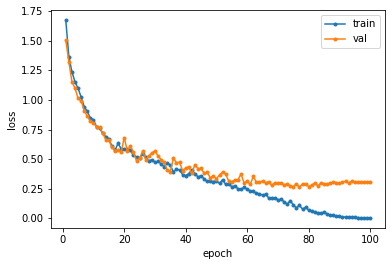

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

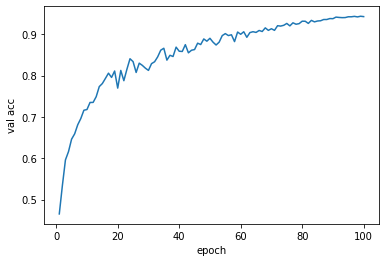

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
plt.show()